# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point. The model code used for training is in the file /models/synch.py.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [45]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats 
import math
import tensorflow as tf

df = pd.read_pickle('data.pkl')
sns.set(style="darkgrid")
np.random.seed(1)

## Exploring the data
Let's look at just one trajectory and plot the coordinates

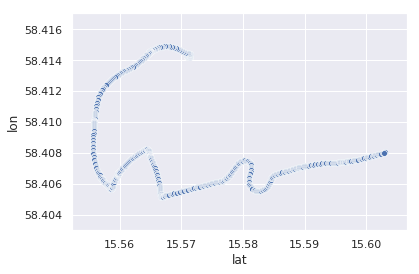

In [46]:
traj_df = df[df.traj == 1]
sns.scatterplot(x="lat", y="lon", data=traj_df)

It looks nice! We can also visualise the segments and their time remaining to next bus stop, where we can see that the behaviour is a bit peaky. This is beacuse data points are filtered out since they are too close in the pre processing step.

/home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


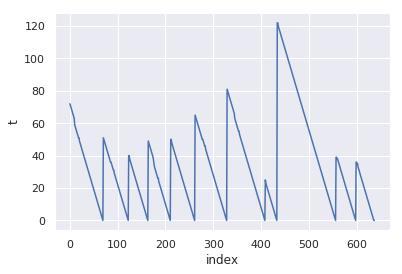

In [47]:
# All segments
traj_df['index'] = traj_df.index
sns.lineplot(data=traj_df, x='index', y='t')

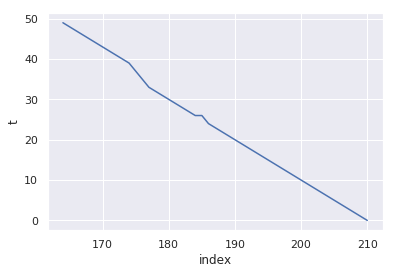

In [48]:
# single segment
sns.lineplot(data=traj_df[traj_df.seg == 4], x='index', y='t')

Since the segments are very different we will train a separate GP for each segment. Let's start out easy and learn a synchronisation function for a nice segment, but first lets plot it.

Segment spatially

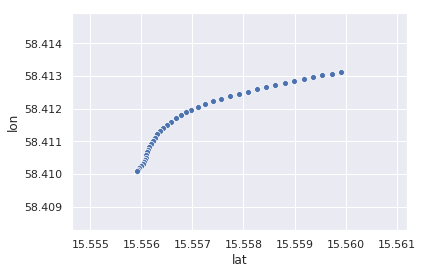

In [49]:
seg = traj_df[traj_df.seg == 3]
sns.scatterplot(x="lat", y="lon", data=seg)

Segment time until arrival

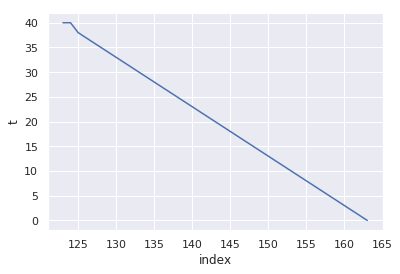

In [50]:
sns.lineplot(data=seg, x='index', y='t')

Segment spatially scaled to zero mean and unit variance

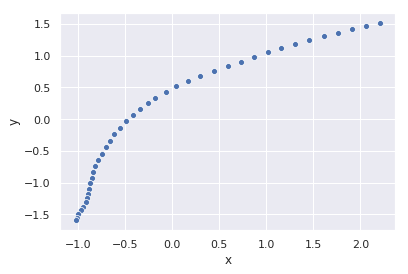

In [51]:
X_unnorm = np.vstack((seg['lat'], seg['lon'])).T 
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)

norm_traj= pd.DataFrame(X, columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

## Hyperparameter Priors
The synchronisation function is a function f : R^2 -> [0, 1] so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance. We will not use this in the conventional sense of learning parameters using MAP (Maximum aposteriori), but for performing random restarts while learning using ML (Maximum likelihood). This needs to be done since GPs are quite prone to getting stuck in local minimas. Let's start with the kernel lengthscale parameter.

### Kernel Lenghtscale (*l*)
When the data was downsampled in the pre processing, it was done with *delta* = 6e-5 which corresponds to approximately 4 metres according to Linus master thesis. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an *l* of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that *l* = 0.0009 gives something that would consider the closest 10 points close and then decay noticeably.

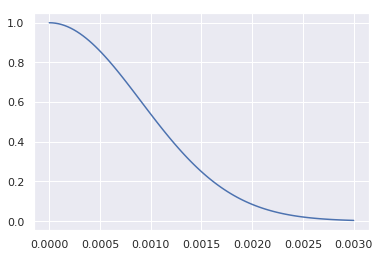

In [52]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 0.003
xx = np.linspace(xmin, xmax, 100)[:,None]
#np.exp((xx-1)*(xx-1))
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.0009)[:,0])

Having concluded a value of *l* that makes sense, we now put a distribution over *l* with its mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that *l* could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

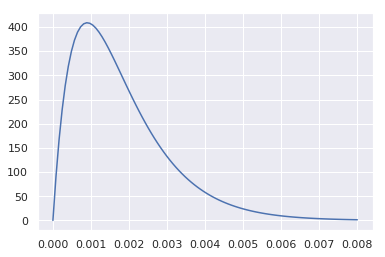

In [53]:
xmin = 0
xmax = 0.008
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=2, scale=0.0009)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance (*sigma_f*)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on [0, 1], the output should not need to vary more than this, so *sigma_f* = 0.4 seems reasonable. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

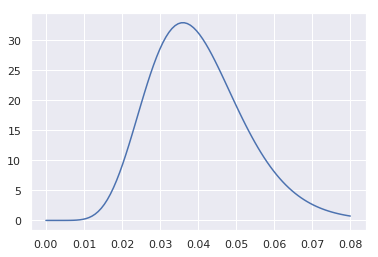

In [54]:
xmin = 0
xmax = 0.08
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=10, scale=0.004)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance (*sigma*)
We also need to chose a prior for the likelihood variance *sigma*, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be *sigma* = 10^-5 so we'll go with that.

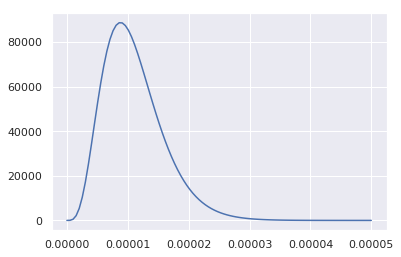

In [55]:
xmin = 0
xmax = 0.00005
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=5, scale=0.0000022)
sns.lineplot(x = xx[:,0], y = y[:,0])

# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation and then evaluate that on other trajectories. As mention in the introduction, the code for training is in the models module which can be found in models/synch.py.

First off we'll split the data into training and validation, then we look at the training data and find a trajectory that has characteristic progression that we want to model.

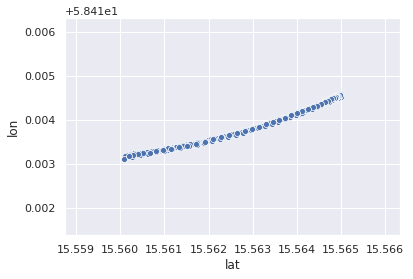

In [85]:
from models import synch
np.random.seed(1)
n_trajs = 100 # Use only a small amount of trajectories to save time
seg_n = 2
traj_n = 50

data = pd.read_pickle('train.pkl')
data = data[(data.traj < n_trajs) & (data.seg == seg_n)]
n_trajs = int(data.traj.max())
n_train = round(n_trajs*0.8)
train_ixs = np.random.randint(0, n_trajs-1, n_train)
train = data[data.traj.transform(lambda x: x in train_ixs)]
valid = data[data.traj.transform(lambda x: x not in train_ixs)]
train_traj = train[train.traj < traj_n]
valid_trajs = valid
sns.scatterplot(x="lat", y="lon", data=train_traj)

After investigating using different segments and trajectories, this one seems like a good enough trajectory, so let's train on it!

In [86]:
train_x = np.vstack((train_traj['lat'], train_traj['lon'])).T
train_y = 1 - np.array(train_traj['t']).reshape(train_traj.shape[0],1) / train_traj['t'].max() # Temporal progress
valid_x = np.vstack((valid_trajs['lat'], valid_trajs['lon'])).T
valid_y = 1 - np.array(valid_trajs['t']).reshape(valid_trajs.shape[0],1) / valid_trajs['t'].max() # Temporal progress

draw_l = lambda: np.random.gamma(2, 0.9)
draw_sigmaf = lambda: np.random.gamma(10, 0.04)
draw_sigma = lambda: np.random.gamma(5, 0.0000022)

n_runs = 10
model, mae = synch.train(train_x, train_y,
                         valid_x, valid_y,
                         n_runs,
                         draw_l, 
                         draw_sigmaf, 
                         draw_sigma)

model.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 37
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 37
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 32
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 32
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 32
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 39
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 39
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 34
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 34
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 31
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 31
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 33
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433480
  Number of iterations: 33
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433479
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804.433479
  Number of iterations: 35
  Number of functions evaluations: 37


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[0.39215931360612305, 0.39215931360612305]"
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.4069131300499418
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.5019026664705945e-05


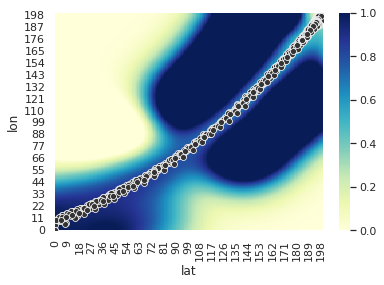

In [87]:
synch.plot_posterior_mean(model, train_traj)

/home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


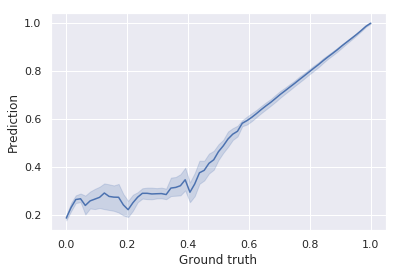

In [88]:
synch.plot_predictions(model, train_x, train_y)

Let's test the performance of the fit on the test data.

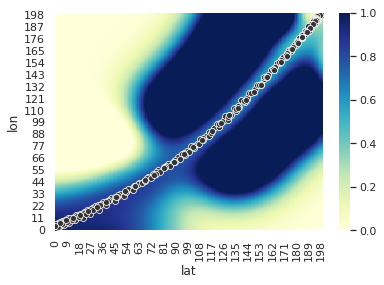

In [89]:
n_test_trajs = 10
test = pd.read_pickle('test.pkl')
test_trajs = test[(test.traj < n_test_trajs) & (test.seg == seg_n)]
synch.plot_posterior_mean(model, test_trajs)

/home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


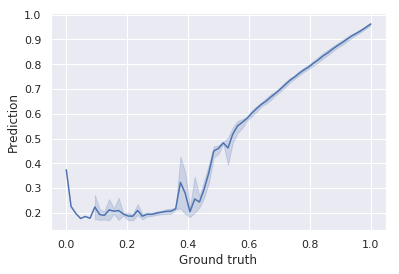

In [90]:
test_x = np.vstack((test_trajs['lat'], test_trajs['lon'])).T
test_y = 1 - np.array(test_trajs['t']).reshape(test_trajs.shape[0],1) / test_trajs['t'].max() # Temporal progress
synch.plot_predictions(model, test_x, test_y)

## Training - Enforcing smoothness
A property that we want from the estimated function is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the domain to be close in the codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want the data is duplicated with a small offset, as can be seen in the figure below.

The code uses the singular value decomposition to compute the eigenvectors of the data, and offset the copies in the direction of the smaller of the two. This approach assumes a nice trajectory with a large first eigenvalue and small second, which will not be the case for all routes, but will probably work well in rural areas where ther aren't many turns.

In [32]:
n_train = 1
seg_n = 3
train_traj = df[df.traj == n_train]
train_seg = train_traj[train_traj.seg == seg_n]
   
    if duplicate_data:
        u, s, vh = np.linalg.svd(X)
        v1 = 1.5*vh[1,:]
        X = np.vstack((X, X+v1, X-v1))
        Y = np.vstack((Y, Y, Y))

#segs = train[train.seg == seg_n]
#test = test[1:len(test)] # First data point has t = 0.0 which is not what the model expects
#train = train[1:len(train)] # First data point has t = 0.0 which is not what the model expects

IndentationError: unexpected indent (<ipython-input-32-36370c647058>, line 6)

In [ ]:
X_unnorm = np.vstack((train_seg['lat'], train_seg['lon'])).T
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)
u, s, vh = np.linalg.svd(X)
v1 = 1.5*vh[1,:]
norm_traj= pd.DataFrame(np.vstack((X, X+v1, X-v1)), columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

The duplicated data has the same labels, so the function will only change in the direction of the spatial progression, which is exactly what we want.  

In [ ]:
def train_gp(X_unnorm, Y, duplicate_data, use_priors):
    scaler = StandardScaler().fit(X_unnorm)
    X = scaler.transform(X_unnorm)
   
    if duplicate_data:
        u, s, vh = np.linalg.svd(X)
        v1 = 1.5*vh[1,:]
        X = np.vstack((X, X+v1, X-v1))
        Y = np.vstack((Y, Y, Y))
        
    
    with gpflow.defer_build():
        rbf = gpflow.kernels.RBF(2, ARD=True)
        m = gpflow.models.GPR(X, Y, rbf, name = 'synch')
    
        if use_priors:
            m.clear()
            m.kern.lengthscales.prior = gpflow.priors.Gamma(5, 0.012)
            m.kern.variance.prior = gpflow.priors.Gamma(5., 8.)
            m.likelihood.variance.prior = gpflow.priors.Gamma(5., 0.000012)

    tf.local_variables_initializer()
    tf.global_variables_initializer()

    tf_session = m.enquire_session()
    m.compile(tf_session)

    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    print(m.as_pandas_table())
    return m, X, Y, tf_session

X = np.vstack((train_seg['lat'], train_seg['lon'])).T   
Y = 1 - np.array(train_seg['t']).reshape(train_seg.shape[0],1) / train_seg['t'].max() # Temporal progress
m, X, Y, tf_session = train_gp(X_unnorm, Y, duplicate_data = True, use_priors = False)

Lets plot the fits mean vs progress. These should be linear if the function maps correctly

In [ ]:
mean, var = m.predict_y(X)
progress_df = pd.DataFrame(np.hstack([X,Y,mean]), columns=list('xypm'))
sns.lineplot(x ='p', y='m', data=progress_df)
m.as_pandas_table()

In [ ]:
def plot_posterior(model, seg): 
    padding = 0 # Padding does not work when overlaying the data in scatterplot (different scales)
    norm_latmax = X[:,0].max() + padding
    norm_latmin = X[:,0].min() - padding 
    norm_longmax = X[:,1].min() - padding
    norm_longmin = X[:,1].max() + padding
    d = 200

    # Prediction mesh
    xlist = np.linspace(norm_latmin, norm_latmax, d)
    ylist = np.linspace(norm_longmin, norm_longmax, d)
    xx, yy = np.meshgrid(xlist, ylist)
    grid = np.array([np.reshape(xx,(-1,)).T,np.reshape(yy,(-1,))]).T
    ax = synch.plot(model, grid)
    # Overlay data scatterplot
    lat_unnorm = seg['lat']
    lon_unnorm = seg['lon']

    # Map data onto heatmap integer space. Worthless, but had no luck in doing the inverse
    lat_grid = ((lat_unnorm-lat_unnorm.min()) / 
                    (lat_unnorm.max() - lat_unnorm.min()))*d
    lon_grid = ((lon_unnorm-lon_unnorm.min()) / 
                    (lon_unnorm.max() - lon_unnorm.min()))*d
    df_grid = pd.DataFrame({'lat':lat_grid, 'lon': lon_grid})
    sns.scatterplot(x='lat', y='lon', data=df_grid, color=".2", axes=hm)

plot_posterior(m, train_seg)

As can bee seen from the two previous plots, the function seem to capture the progression of the training data very well. The question is, will it generalise?

In [ ]:
n_test = 20
test_traj = df[df.traj <= n_test]
test_seg = test_traj[test_traj.seg == seg_n]
plot_posterior(m, test_seg)

This plot looks very promising indeed! For this very nice segement the synchonisation seem to have been successful. Let's try the same approach on a harder one.

In [ ]:
hard_seg = traj_df[traj_df.seg == 9]
sns.scatterplot(x="lat", y="lon", data=hard_seg)

Trying to duplicate the data with an offset in the direction of the smallest eigenvalue is shown to be a terrible strategy for this segment as can be seen below, so let's just train on the original segment for now.

In [ ]:
X_unnorm = np.vstack((hard_seg['lat'], hard_seg['lon'])).T
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)
u, s, vh = np.linalg.svd(X)
v1 = 1.5*vh[1,:]
norm_traj= pd.DataFrame(np.vstack((X, X+v1, X-v1)), columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

In [ ]:
X = np.vstack((hard_seg['lat'], hard_seg['lon'])).T
Y = 1 - np.array(hard_seg['t']).reshape(hard_seg.shape[0],1) / train_seg['t'].max() # Temporal progress
m, X, Y, tf_session = train_gp(X, Y, duplicate_data = False, use_priors = False)
plot_posterior(m, hard_seg)

Somewhat expected, this model does not work on more complicated segments, but it can be used to make predictions on simpler ones for now.

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(tf_session, "./synch-gp.ckpt")
print("Model saved in path: %s" % save_path)